Plan

1. Preprocess data

2. Use ___ to build an anomaly detection model

3. Find feature importance of variables after model is finished training

4. Summarize results

In [ ]:
# Commented Out Code:

# print(alldata.columns)
# alldata.head()
# filt = ['fare_amount', 'extra', 'mta_tax','tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'Airport_fee']
# fare_values = alldata[filt]
# fare_values["airport_fee"] = fare_values["airport_fee"].fillna(0.00)
# fare_values["Airport_fee"] = fare_values["Airport_fee"].fillna(0.00)
# fare_values["airport_fee"] = np.maximum(fare_values['airport_fee'], fare_values['Airport_fee'])

# fare_values["total_amount"] = fare_values["fare_amount"] + fare_values["extra"] + fare_values["mta_tax"] + fare_values["tip_amount"] + fare_values["tolls_amount"] + fare_values["improvement_surcharge"] + fare_values["congestion_surcharge"] + fare_values["airport_fee"]
# # fare_values.drop(columns=["Airport_fee"], inplace=True)

# filt2 = fare_values['airport_fee'] > 0
# fare_values[filt2]

# drop some redundant columns (very sparce columns)
# alldata = alldata.drop(columns=['improvement_surcharge', 'payment_type_5', 'store_and_fwd_flag'])
# unknown payment type and the charge which is applied on pretty much every transaction
# alldata = alldata.drop(columns=['improvement_surcharge', 'payment_type_5'])

# def fun(a):
#   return (a-1, a+1)

# alldata["pickup_x"] = alldata["PULocationID"].apply(lambda x: fun(x)[0])
# alldata["pickup_y"] = alldata["PULocationID"].apply(lambda x: fun(x)[1])
# alldata["dropoff_x"] = alldata["DOLocationID"].apply(lambda x: fun(x)[0])
# alldata["dropoff_y"] = alldata["DOLocationID"].apply(lambda x: fun(x)[1])

# alldata[['DOLocationID', 'dropoff_x', 'dropoff_y',
#          'PULocationID', 'pickup_x', 'pickup_y']]


# Data preprocessing + cleaning

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pip uninstall numpy

In [157]:
pip install -r requirements.txt

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [158]:
# root = './drive/MyDrive/Colab Notebooks/ADA-1005-Project'
import os
root = os.getcwd()

In [159]:
import pandas as pd
import numpy as np

In [160]:
# concatenate all files into single dataframe
# alldata = (pd.read_parquet(f"cleaned_data/1.parquet")).head(1500000)
alldata = pd.DataFrame()
frames = []

# About at least 32 GB of RAM required to run a few months

# Just January 2023
frames.append(pd.read_parquet(f"{root}/data/2023/yellow_tripdata_2023-01.parquet"))

# # Looking at the range of Jan 1st to June 31st ~ 2023
# for i in range(1, 7):
#   val = str(i).zfill(2)
#   data = pd.read_parquet(f"{root}/data/2023/yellow_tripdata_2023-{val}.parquet")
#   frames.append(data)
# for i in range(7, 13):
#   val = str(i).zfill(2)
#   data = pd.read_parquet(f"{root}/data/2023/yellow_tripdata_2023-{val}.parquet")
#   frames.append(data)
# for i in range(1, 7):
#   val = str(i).zfill(2)
#   data = pd.read_parquet(f"{root}/data/2024/yellow_tripdata_2023-{val}.parquet")
#   frames.append(data)
# for i in range(7, 13):
#   val = str(i).zfill(2)
#   data = pd.read_parquet(f"{root}/data/2024/yellow_tripdata_2023-{val}.parquet")
#   frames.append(data)

alldata = pd.concat(frames)

# print(alldata.columns)
# print(alldata.shape)
# alldata.head()

In [161]:
from datetime import datetime,timezone

# Define the datetime string (UTC)
datetime_str = '2023-01-01 00:00:00' # Cut dates before Jan 1st 2023 - midnight
dt = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
start_timestamp = int(dt.timestamp())
datetime_str = '2023-02-01 00:00:00' # Cut dates after Feb 1st 2023 - midnight
dt = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S').replace(tzinfo=timezone.utc)
end_timestamp = int(dt.timestamp())
print(start_timestamp, end_timestamp)

1672531200 1675209600


In [162]:
# turn date-time into numerical values
alldata['tpep_pickup_datetime'] = pd.to_datetime(alldata['tpep_pickup_datetime']).astype('int64') // 10e5
alldata['tpep_dropoff_datetime'] = pd.to_datetime(alldata['tpep_dropoff_datetime']).astype('int64') // 10e5

# turn 'N' and 'Y' into 0 and 1
alldata["store_and_fwd_flag"] = alldata["store_and_fwd_flag"].map(lambda x: 0 if x == "N" else 1)

try: # If there is an "Airport fee column"
    # fillNA with zeroes
    alldata["airport_fee"] = alldata["airport_fee"].fillna(0.00)
    alldata["Airport_fee"] = alldata["Airport_fee"].fillna(0.00)
    alldata["airport_fee"] = np.maximum(alldata['airport_fee'], alldata['Airport_fee'])

    # drop unwanted columns
    alldata = alldata.drop(columns=["Airport_fee", "total_amount"])
except:
    alldata["airport_fee"] = alldata["airport_fee"].fillna(0.00)
    alldata = alldata.drop(columns=["total_amount"])

# change the negative values to positive
alldata = alldata.abs()

# new total amount (some of the total amounts exclude the congestion_surcharge and airport_fee)
alldata["total_amount"] = alldata["fare_amount"] + alldata["extra"] + alldata["mta_tax"] + alldata["tip_amount"] + alldata["tolls_amount"] + alldata["improvement_surcharge"] + alldata["congestion_surcharge"] + alldata["airport_fee"]
alldata.drop(columns=['fare_amount'])

# one-hot encode nominal categories
alldata = pd.get_dummies(alldata, columns=['VendorID', 'RatecodeID', 'payment_type'], prefix_sep='_', dtype=int)

# change all to floats
alldata = alldata.astype({col: float for col in alldata.select_dtypes(include='int').columns})

# print(alldata.columns)
# print(alldata.dtypes)
alldata.head()
# sorted_stuff = alldata.sort_values(by='total_amount')

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,mta_tax,...,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4
0,1.672533e+09,1.672534e+09,1.0,0.97,0.0,161.0,141.0,9.3,1.00,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.672535e+09,1.672535e+09,1.0,1.10,0.0,43.0,237.0,7.9,1.00,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.672533e+09,1.672533e+09,1.0,2.51,0.0,48.0,238.0,14.9,1.00,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.672531e+09,1.672532e+09,0.0,1.90,0.0,138.0,7.0,12.1,7.25,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.672532e+09,1.672532e+09,1.0,1.43,0.0,107.0,79.0,11.4,1.00,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [163]:
# remove values from before start and after end
filt1 = alldata['tpep_pickup_datetime'] < start_timestamp
filt2 = alldata['tpep_pickup_datetime'] > end_timestamp
filt = (filt1) | (filt2)
alldata = alldata[~filt]

In [164]:
# cost_per_mile w/inaccurate values for inconsistent total_amount and trip distace
alldata['cost_per_mile'] = alldata['total_amount']/alldata['trip_distance']

# calculate the average cost/mile for non zero values
filt = (alldata['trip_distance'] != 0) & (alldata['total_amount'] != 0)
avgCPK = alldata[filt].mean()['cost_per_mile']
avgTotal = alldata[filt].mean()['total_amount']
avgDist = alldata[filt].mean()['trip_distance']

# if both metrics are 0, then drop
filt = (alldata['trip_distance'] == 0) & (alldata['total_amount'] == 0)
alldata = alldata[~filt]

# if only the distance is 0 the CPK is the average and the distance is calculated using the amount
filt = (alldata['trip_distance'] == 0)
alldata.loc[filt, 'trip_distance'] = avgCPK/alldata.loc[filt, 'total_amount']
alldata.loc[filt, 'cost_per_mile'] = alldata.loc[filt, 'total_amount']/alldata.loc[filt, 'trip_distance']

# if only the total_amount is 0 the CPK is the average and the total is calculated using the distance
filt = (alldata['total_amount'] == 0)
alldata.loc[filt, 'total_amount'] = avgCPK * alldata.loc[filt, 'trip_distance']
alldata.loc[filt, 'cost_per_mile'] = alldata.loc[filt, 'total_amount']/alldata.loc[filt, 'trip_distance']


# if both are unknown, then drop
filt = (alldata["PULocationID"] == 264) & (alldata["DOLocationID"] == 264)
alldata = alldata[~filt]

# if one is unknown, then use the other value
filt = (alldata["PULocationID"] == 264) & ~(alldata["DOLocationID"] == 264) # pickup location is unknown
alldata.loc[filt, 'PULocationID'] = alldata.loc[filt, 'DOLocationID']
filt = ~(alldata["PULocationID"] == 264) & (alldata["DOLocationID"] == 264) # dropoff location is unknown
alldata.loc[filt, 'DOLocationID'] = alldata.loc[filt, 'PULocationID']

# Sort values by pickup time
alldata.sort_values(by='tpep_pickup_datetime', inplace=True)
alldata.dropna(inplace=True) # drop missing values
# alldata[['cost_per_mile', 'total_amount', 'trip_distance']]

In [165]:
# Drop these values too for now because they are weird
filt = (alldata["PULocationID"] == 265) | (alldata["DOLocationID"] == 265)
alldata = alldata[~filt]
filt = (alldata["PULocationID"] == 57) | (alldata["DOLocationID"] == 57)
alldata = alldata[~filt]
filt = (alldata["PULocationID"] == 105) | (alldata["DOLocationID"] == 105)
alldata = alldata[~filt]

# Group by nearest Locations

In [127]:
import json

def read_dict(key, key_dict, var):
  if var == 'x':
    return key_dict[(str)((int)(key))][0]
  elif var == 'y':
    return key_dict[(str)((int)(key))][1]
  else:
    raise ValueError("Invalid var")
    return

with open("zone_positions.json", 'r') as file:
    key_dict = json.load(file) 
alldata["pickup_x"] = alldata["PULocationID"].apply(lambda x: read_dict(x,key_dict, 'x'))
alldata["pickup_y"] = alldata["PULocationID"].apply(lambda x: read_dict(x,key_dict, 'y'))
alldata["dropoff_x"] = alldata["DOLocationID"].apply(lambda x: read_dict(x,key_dict, 'x'))
alldata["dropoff_y"] = alldata["DOLocationID"].apply(lambda x: read_dict(x,key_dict, 'y'))


# alldata[['DOLocationID', 'dropoff_x', 'dropoff_y',
#          'PULocationID', 'pickup_x', 'pickup_y']]

# filt = (alldata["PULocationID"] == 265) | (alldata["DOLocationID"] == 265)
# alldata[filt]

# Reduce to first 10000 entries

In [128]:
# (Lite Version) Reduce it for sampling
alldata = alldata.head(10000)

In [129]:
# Reorder Nearest Neighbors
from ZoneDistance.reorder_nearest_rows import reorder_nearest_rows
alldata = reorder_nearest_rows(alldata)

In [132]:
# pickling the data to use for later
alldata.to_pickle("lite_alldata_jan-2023.pkl")

# Build an Anomaly Detection model

In [196]:
import pandas as pd

# unpicklize it
alldata = pd.read_pickle("lite_alldata_jan-2023.pkl")

In [ ]:
from sklearn.ensemble import IsolationForest

# Create features (lags, rolling statistics, etc.)
alldata['lag_1'] = alldata['cost_per_mile'].shift(1)
alldata['rolling_mean_cost_per_mile'] = alldata['cost_per_mile'].rolling(window=20).mean()

# Drop Na from rolling mean
alldata.dropna(inplace=True)

# Define features, ignore some of the independent features
# X = alldata
# X = alldata[['lag_1', 'rolling_mean_cost_per_mile']]

# Train Isolation Forest
model = IsolationForest(contamination=0.10, n_estimators=300, max_samples='auto')
alldata['anomaly'] = model.fit_predict(X)

# -1 indicates an anomaly, 1 indicates normal - changes numbers to strings
# alldata['anomaly'] = alldata['anomaly'].apply(lambda x: 'anomaly' if x == -1 else 'normal')

alldata.drop(columns=['lag_1', 'rolling_mean_cost_per_mile'], inplace=True)

In [ ]:
# # more pickleization (with anomalies) 🥒🥒🥒
# alldata.to_pickle("lite_alldata_anomaly_jan-2023.pkl") # trained on ['lag_1' and 'rolling_mean_cost_per_mile']
# alldata.to_pickle("everything_lite_alldata_anomaly_jan-2023.pkl") # trained on everything AND ['lag_1' and 'rolling_mean_cost_per_mile']

# Extract the important features

### Everything Graphs

In [208]:
import pandas as pd

# unpicklize it 🥒🥒🥒
# alldata = pd.read_pickle("lite_alldata_anomaly_jan-2023.pkl")
alldata = pd.read_pickle("everything_lite_alldata_anomaly_jan-2023.pkl")

# Make the 'anomaly_color' column is properly added
alldata['anomaly_color'] = alldata['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

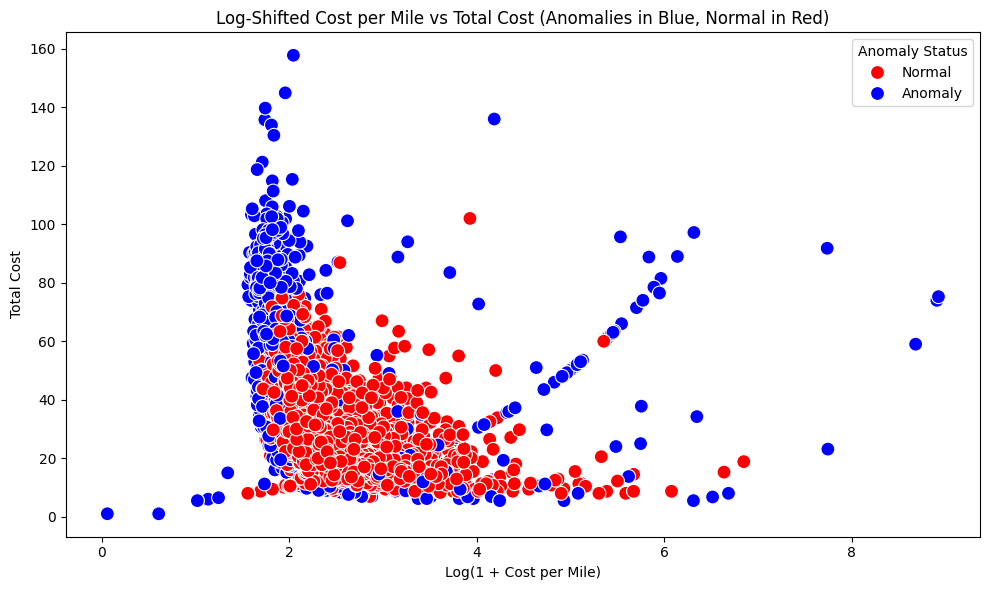

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Apply a log shift to the 'cost_per_mile' column (log1p adds 1 to avoid log(0))
alldata['log_cost_per_mile'] = np.log1p(alldata['cost_per_mile'])

# Create the scatter plot with log-transformed x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_cost_per_mile', y='total_amount', data=alldata, hue='anomaly_color', palette={'Anomaly': 'blue', 'Normal': 'red'}, s=100)

# Customizing the plot
plt.title('Log-Shifted Cost per Mile vs Total Cost (Anomalies in Blue, Normal in Red)')
plt.xlabel('Log(1 + Cost per Mile)')
plt.ylabel('Total Cost')
plt.legend(title='Anomaly Status')
plt.tight_layout()

# Show the plot
plt.show()

# drop the log column
alldata.drop(columns=['log_cost_per_mile'], inplace=True)


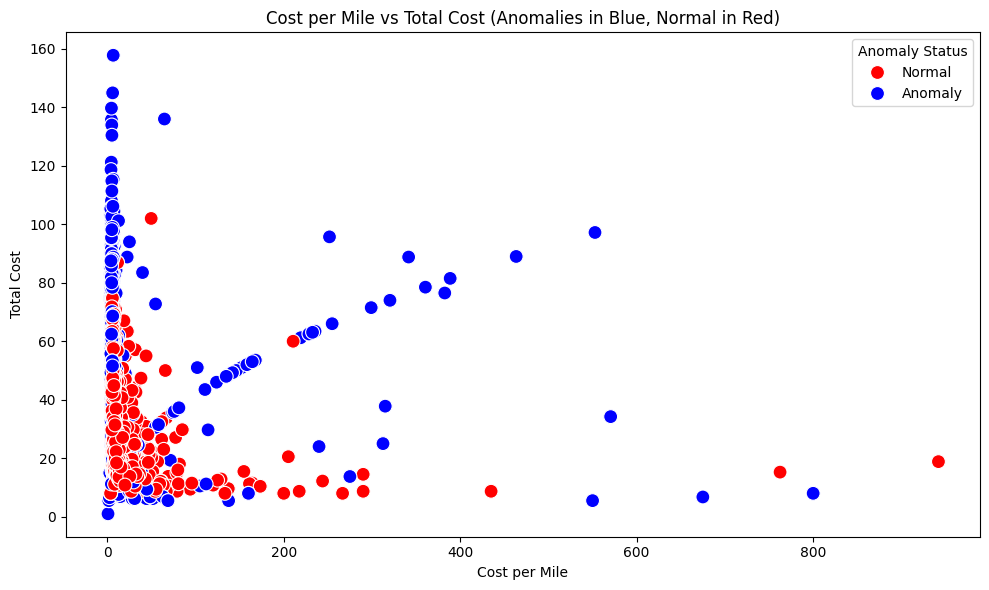

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the scatter plot with log-transformed x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cost_per_mile', y='total_amount', data=alldata[alldata['cost_per_mile']<1000], hue='anomaly_color', palette={'Anomaly': 'blue', 'Normal': 'red'}, s=100)

# Customizing the plot
plt.title('Cost per Mile vs Total Cost (Anomalies in Blue, Normal in Red)')
plt.xlabel('Cost per Mile')
plt.ylabel('Total Cost')
plt.legend(title='Anomaly Status')
plt.tight_layout()

# Show the plot
plt.show()

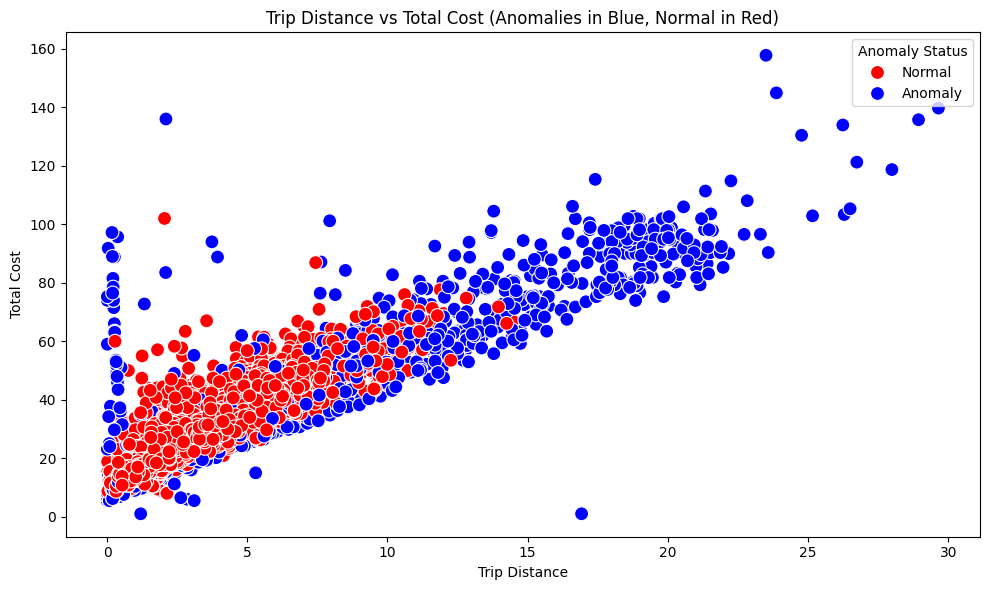

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the scatter plot with log-transformed x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='total_amount', data=alldata, hue='anomaly_color', palette={'Anomaly': 'blue', 'Normal': 'red'}, s=100)

# Customizing the plot
plt.title('Trip Distance vs Total Cost (Anomalies in Blue, Normal in Red)')
plt.xlabel('Trip Distance')
plt.ylabel('Total Cost')
plt.legend(title='Anomaly Status')
plt.tight_layout()

# Show the plot
plt.show()


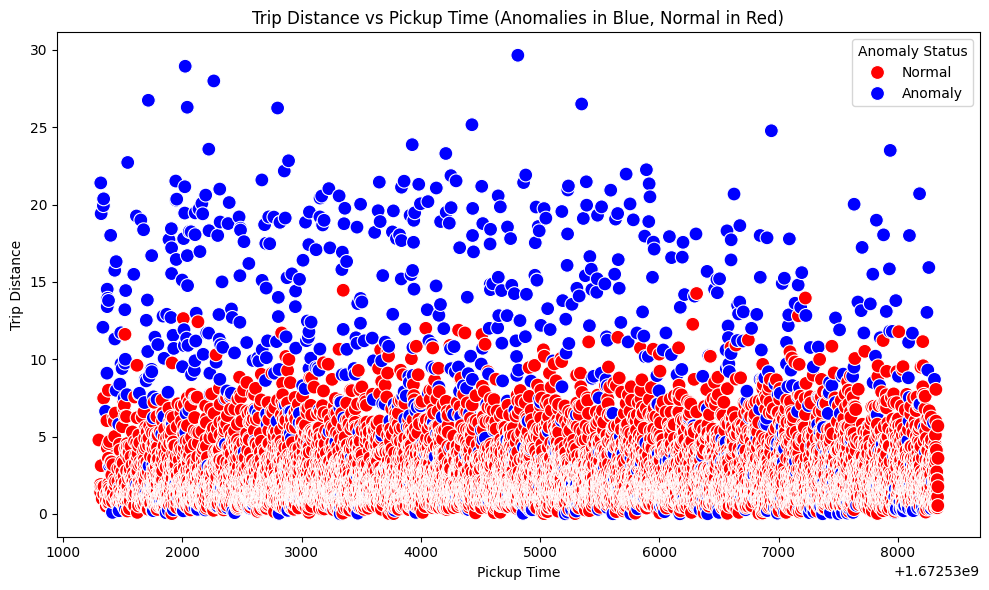

In [212]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create the scatter plot with log-transformed x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tpep_pickup_datetime', y='trip_distance', data=alldata, hue='anomaly_color', palette={'Anomaly': 'blue', 'Normal': 'red'}, s=100)

# Customizing the plot
plt.title('Trip Distance vs Pickup Time (Anomalies in Blue, Normal in Red)')
plt.xlabel('Pickup Time')
plt.ylabel('Trip Distance')
plt.legend(title='Anomaly Status')
plt.tight_layout()

# Show the plot
plt.show()


### Just the Lag and Cost per Km Graph

In [213]:
import pandas as pd

# unpicklize it 🥒🥒🥒
alldata = pd.read_pickle("lite_alldata_anomaly_jan-2023.pkl")
# alldata = pd.read_pickle("everything_lite_alldata_anomaly_jan-2023.pkl")

# Make the 'anomaly_color' column is properly added
alldata['anomaly_color'] = alldata['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

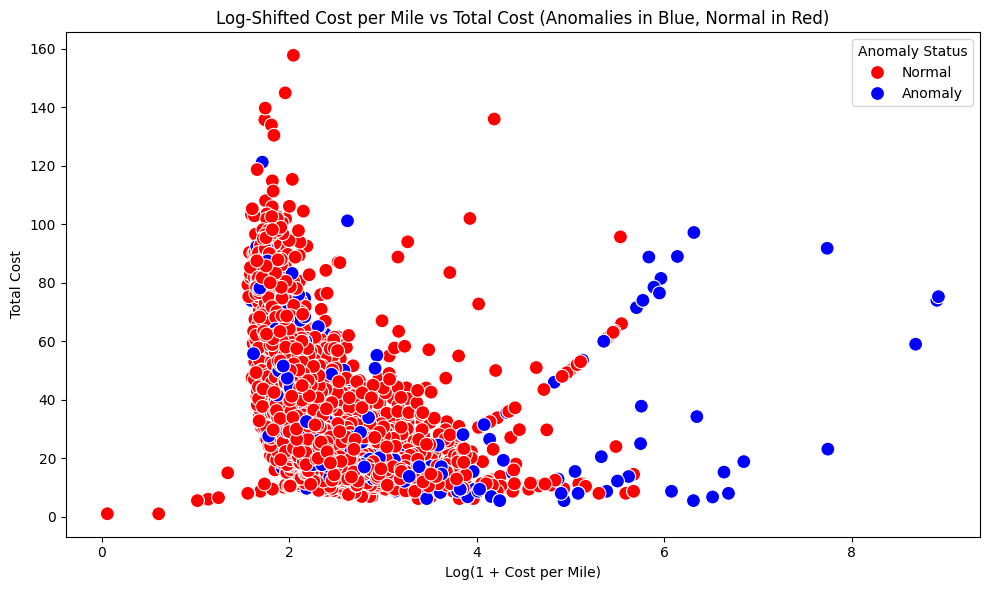

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Apply a log shift to the 'cost_per_mile' column (log1p adds 1 to avoid log(0))
alldata['log_cost_per_mile'] = np.log1p(alldata['cost_per_mile'])

# Create the scatter plot with log-transformed x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_cost_per_mile', y='total_amount', data=alldata, hue='anomaly_color', palette={'Anomaly': 'blue', 'Normal': 'red'}, s=100)

# Customizing the plot
plt.title('Log-Shifted Cost per Mile vs Total Cost (Anomalies in Blue, Normal in Red)')
plt.xlabel('Log(1 + Cost per Mile)')
plt.ylabel('Total Cost')
plt.legend(title='Anomaly Status')
plt.tight_layout()

# Show the plot
plt.show()

# drop the log column
alldata.drop(columns=['log_cost_per_mile'], inplace=True)

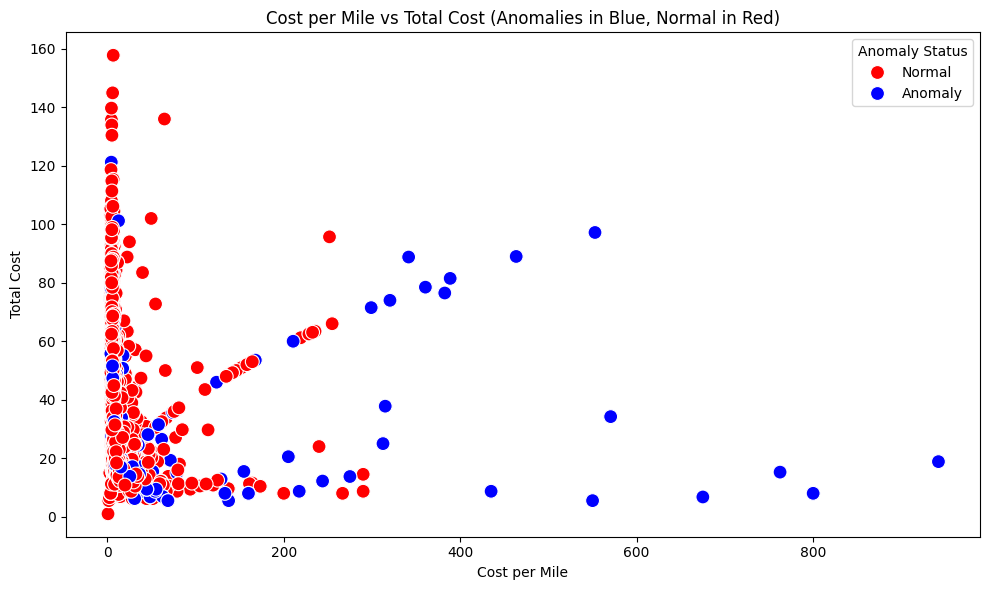

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the scatter plot with log-transformed x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cost_per_mile', y='total_amount', data=alldata[alldata['cost_per_mile']<1000], hue='anomaly_color', palette={'Anomaly': 'blue', 'Normal': 'red'}, s=100)

# Customizing the plot
plt.title('Cost per Mile vs Total Cost (Anomalies in Blue, Normal in Red)')
plt.xlabel('Cost per Mile')
plt.ylabel('Total Cost')
plt.legend(title='Anomaly Status')
plt.tight_layout()

# Show the plot
plt.show()

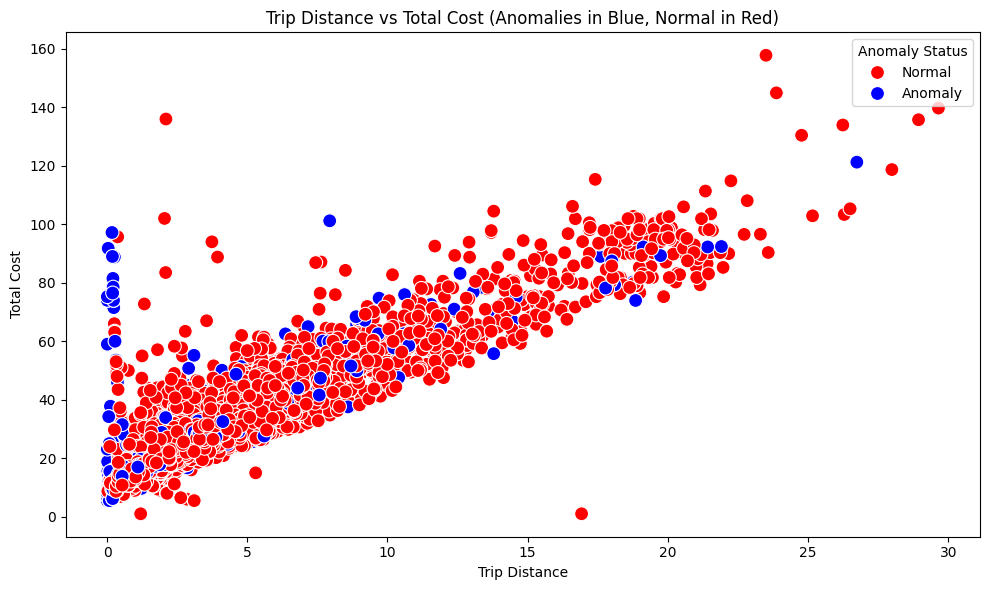

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the scatter plot with log-transformed x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='total_amount', data=alldata, hue='anomaly_color', palette={'Anomaly': 'blue', 'Normal': 'red'}, s=100)

# Customizing the plot
plt.title('Trip Distance vs Total Cost (Anomalies in Blue, Normal in Red)')
plt.xlabel('Trip Distance')
plt.ylabel('Total Cost')
plt.legend(title='Anomaly Status')
plt.tight_layout()

# Show the plot
plt.show()

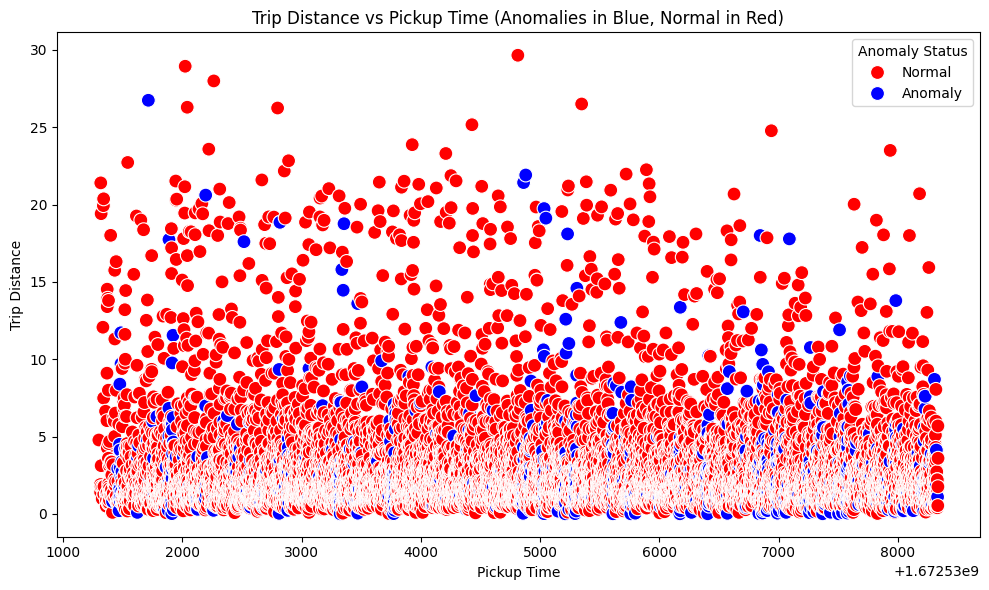

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create the scatter plot with log-transformed x-axis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tpep_pickup_datetime', y='trip_distance', data=alldata, hue='anomaly_color', palette={'Anomaly': 'blue', 'Normal': 'red'}, s=100)

# Customizing the plot
plt.title('Trip Distance vs Pickup Time (Anomalies in Blue, Normal in Red)')
plt.xlabel('Pickup Time')
plt.ylabel('Trip Distance')
plt.legend(title='Anomaly Status')
plt.tight_layout()

# Show the plot
plt.show()